In [1]:
%matplotlib inline

In [2]:
import os
import re
import codecs
import gensim
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from gensim.models import word2vec
from scipy import stats, integrate

sns.set(style="darkgrid")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Preprocessing

In [3]:
read_file = pd.read_json("data/Dashmote_data_set_case.json", lines = True)

In [4]:
read_file.describe()

,comments,date_month,date_unix,date_week,likes,user_id
count,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,1.000000e+04
mean,3.108700,1.95330,1.485768e+09,18.312900,56.343700,1.692523e+09
std,23.615441,0.69323,1.774091e+06,20.273581,68.537291,1.481797e+09
min,0.000000,1.00000,1.483225e+09,5.000000,0.000000,1.174800e+04
25%,0.000000,1.00000,1.483308e+09,5.000000,19.750000,2.808167e+08
50%,1.000000,2.00000,1.485952e+09,5.000000,37.000000,1.463377e+09
75%,3.000000,2.00000,1.485986e+09,52.000000,68.000000,3.009536e+09
max,2311.000000,3.00000,1.488409e+09,52.000000,2808.000000,4.742553e+09


In [5]:
read_file.sample(5)

,cluster,comments,date_formated,date_month,date_unix,date_week,hashtags,id,likes,url,user_id
1715,wetlook,3,01-01-2017,1,1483299490,52,"[#wet, #wetlook, #totallywet, #wetgirl, #wetcl...",BOu9fpSAVAY,142,https://scontent-vie1-1.cdninstagram.com/t51.2...,3958353011
490,longbobhair,18,01-01-2017,1,1483238142,52,"[#happynewyear, #vem2017, #hair, #haircut, #lo...",BOtIe2GhFky,140,https://scontent-vie1-1.cdninstagram.com/t51.2...,246194534
3127,mediumhair,0,01-02-2017,2,1485953100,5,"[#balayage, #mediumhair, #wavyhair, #beautiful]",BP-C2m8DhIh,14,https://scontent-vie1-1.cdninstagram.com/t51.2...,1096813675
4707,tousledhair,6,01-02-2017,2,1485963482,5,"[#polishgirl, #me, #fit, #fitgirl, #muscle, #b...",BP-Wp7kgl0Z,129,https://scontent-vie1-1.cdninstagram.com/t51.2...,3957247923
8241,moisture,0,01-03-2017,3,1488332235,9,"[#earthquake, #fema, #climate, #climatechange,...",BRE8sYuhKmG,17,https://scontent-vie1-1.cdninstagram.com/t51.2...,3657587771


In [6]:
# deriving new features
read_file["no_of_tags"] = read_file["hashtags"].apply(len)

In [7]:
for col in list(read_file.columns):
    try: 
        print("{}: {} unique items". format(col, read_file[str(col)].nunique()))
    except:
        print("{} is unhashable".format(col))
        continue

cluster: 124 unique items
comments: 59 unique items
date_formated: 3 unique items
date_month: 3 unique items
date_unix: 9748 unique items
date_week: 3 unique items
hashtags is unhashable
id: 10000 unique items
likes: 386 unique items
url: 10000 unique items
user_id: 7953 unique items
no_of_tags: 48 unique items


In [8]:
# Removing outliers
temp = read_file[["comments", "likes", "no_of_tags"]]

In [9]:
for col in list(temp.columns):
    read_file[str(col)] = read_file[str(col)][~((read_file[str(col)]-read_file[str(col)].mean()).abs()>3*read_file[str(col)].std())]
    read_file[str(col)] = np.where(read_file[str(col)].isna(), 0, read_file[str(col)])

In [10]:
# normalising data for proper comparision
temp = read_file[["comments", "likes"]]
temp = (temp - temp.mean()) / (temp.max() - temp.min())

/home/tharangni/Documents/misc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


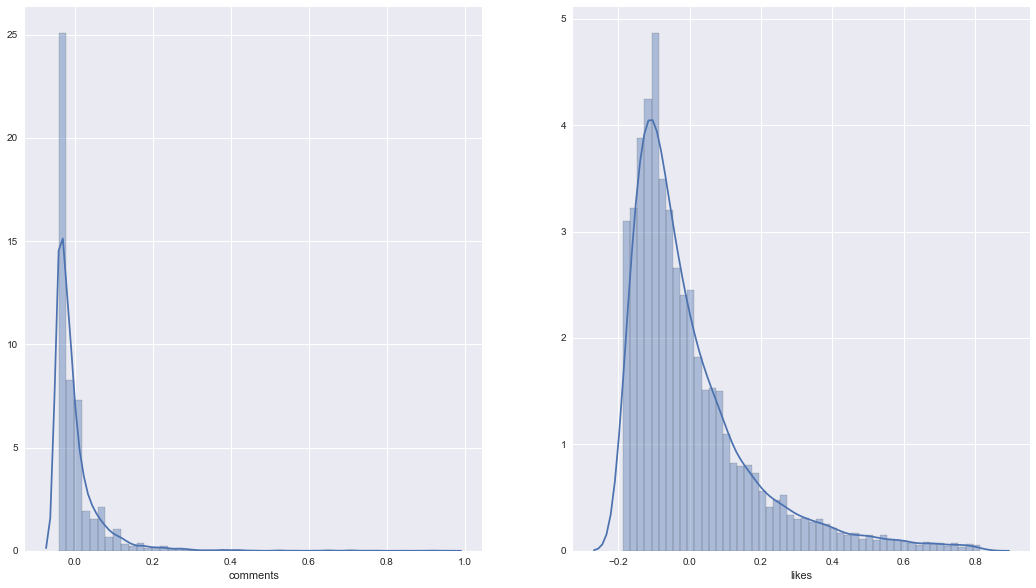

In [11]:
plt.rcParams['figure.figsize'] = [18, 10]
plt.subplot(1, 2, 1)
sns.distplot(temp["comments"], hist_kws=dict(edgecolor="k"))
plt.subplot(1, 2, 2)
sns.distplot(temp["likes"], hist_kws=dict(edgecolor="k"))

# Clearly, it is better to use "likes" as a measure of popularity
# Also, some posts might have comments diabled. Hence, it's better to use likes as a measure of popularity

## Global Insights

In [12]:
read_file["date_month"].value_counts()
# February received the most number of posts followed by January
# Possible reasons: Valentine's day and New Year/Christmas 

2    5173
1    2647
3    2180
Name: date_month, dtype: int64

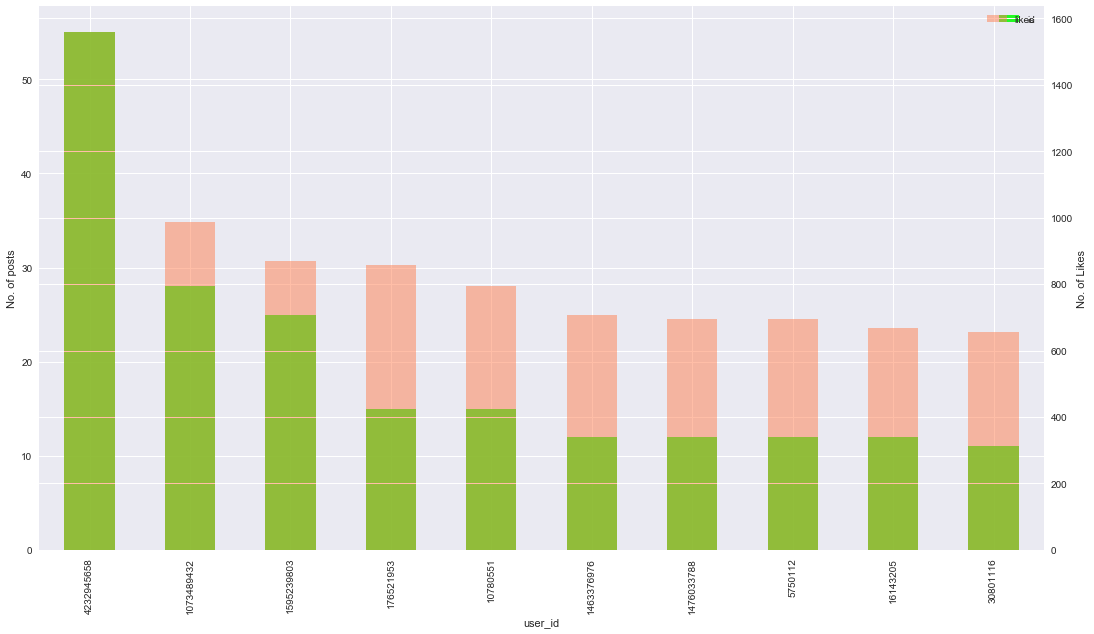

In [13]:
plt.rcParams['figure.figsize'] = [18, 10]

mini = read_file[["user_id", "id"]]
# user_posts = read_file["user_id"].value_counts()
user_posts = mini.groupby(["user_id"]).count()
user_posts = user_posts.sort_values(by = ["id"], ascending=False)

user_likes =  read_file[["user_id", "likes", "id"]]
temp = user_likes.groupby(["user_id"], axis = 0, sort = True).sum()
temp = temp.sort_values(by = ["likes"], ascending=False)

fig, ax = plt.subplots()
ax2 = ax.twinx()
user_posts.head(10).plot(kind = "bar", color = "lime", alpha = 0.85, ax=ax)
ax.set_ylabel("No. of posts")
temp.head(10).plot(kind="bar", ax=ax2, alpha = 0.5, color = "coral")
ax2.set_ylabel("No. of Likes")

plt.show()
# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() *1.004, p.get_height() * 1.008))

# we realise that the user who posted the most also had most number of likes

### Ideas for further global analysis: 
- Obtain the time users were most active by deriving a `time` feature from `date_unix`

## Hairstyles

In [14]:
hairstyle_cluster_list = read_file["cluster"].value_counts(sort = True)

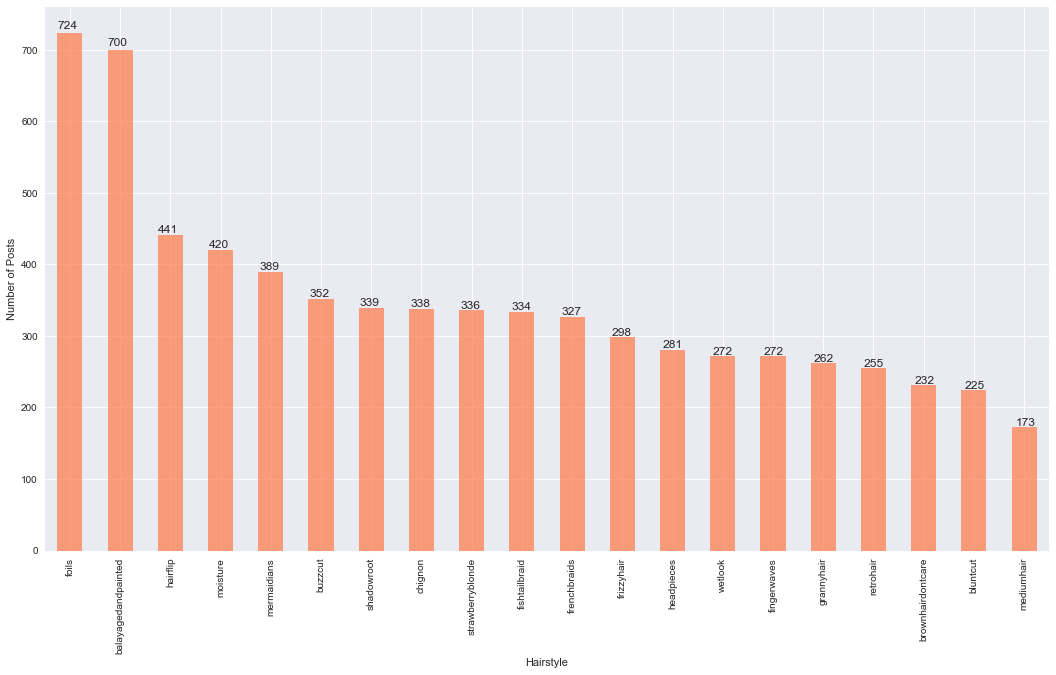

In [15]:
plt.rcParams['figure.figsize'] = [18, 10]
ax = hairstyle_cluster_list.head(20).plot(kind = "bar", color = "coral", alpha = 0.75)
ax.set_xlabel("Hairstyle")
ax.set_ylabel("Number of Posts")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() *1.004, p.get_height() * 1.008))
    
# Clearly the most popular hairstyles are "foils" and "balayagedandpainted"

/home/tharangni/Documents/misc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Likes recorded')

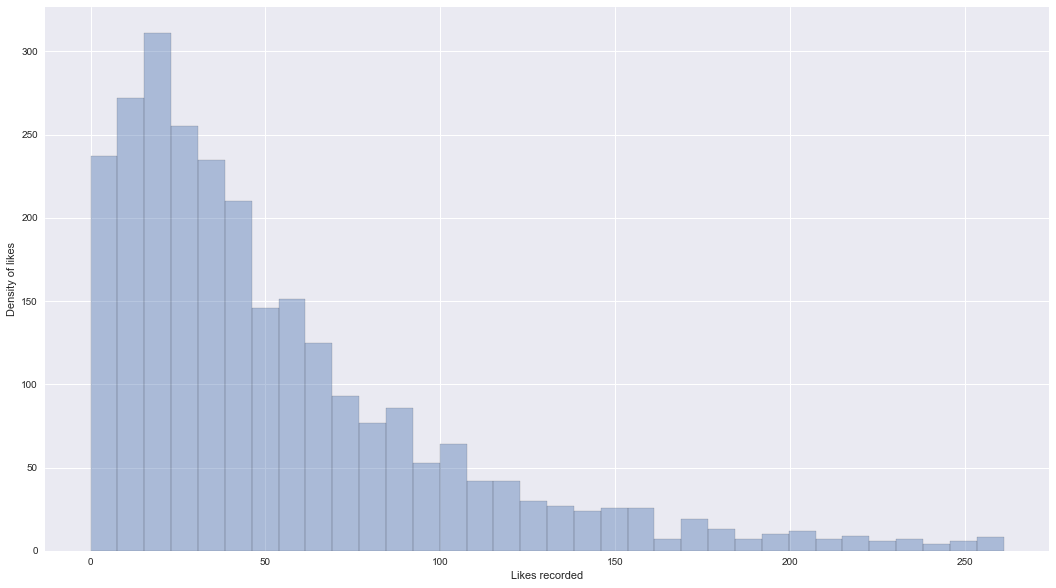

In [16]:
# looking at stuff for the first month i.e. january (make a function for months basically and make analyses similarly)
jan_data = read_file[read_file["date_month"] == 1]
ax = sns.distplot(jan_data["likes"], kde = False,  hist_kws=dict(edgecolor="k"))
ax.set_ylabel("Density of likes")
ax.set_xlabel("Likes recorded")

### Ideas for further hairstyle analysis: 
- Derive monthly hairtrends, popularity etc

## Relationships in Hashtags

In [17]:
temp = read_file[["no_of_tags", "likes"]]

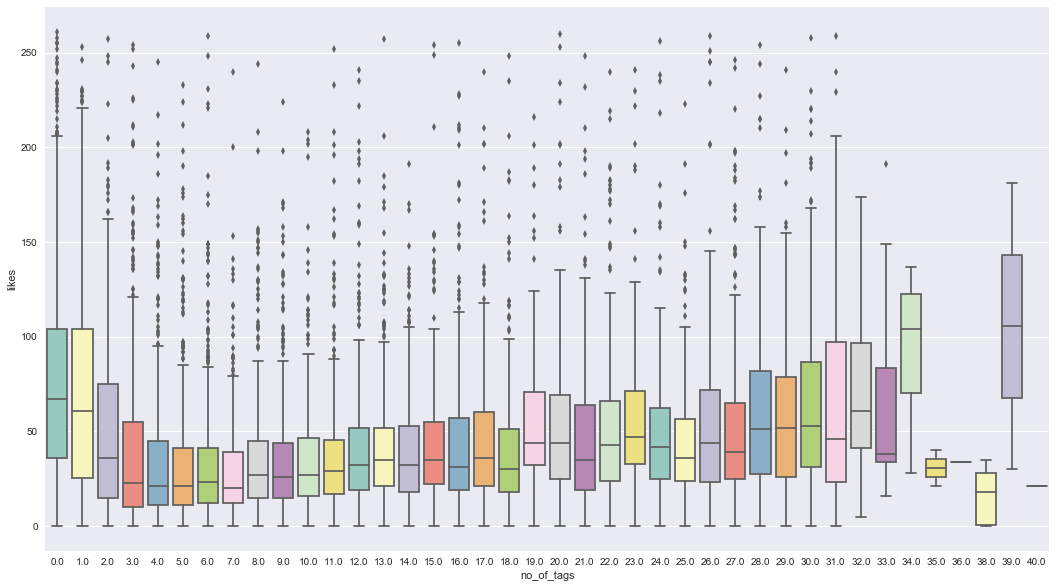

In [18]:
plt.rcParams['figure.figsize'] = [18, 10]
# sns.heatmap(temp)
sns.boxplot(x="no_of_tags", y="likes", data=temp, palette="Set3")

#No. of tags don't decide the popularity of a post

In [19]:
corpus = []

In [20]:
def clean_data(pd_series):
#     print(pd_series)
    for k, v in pd_series.iteritems():
        for tags in v:
            if tags not in corpus:
                corpus.append(tags)
    hashes = ' '.join([str(item) for sublist in corpus for item in sublist]) 
    return corpus, hashes

In [21]:
tags_w_likes, hashes = clean_data(read_file[["hashtags"]])

In [22]:
wordcloud = WordCloud(
    background_color='white', 
    width=900, 
    height=600, 
    max_words=50, 
    max_font_size=400, colormap="gist_ncar").generate(hashes)

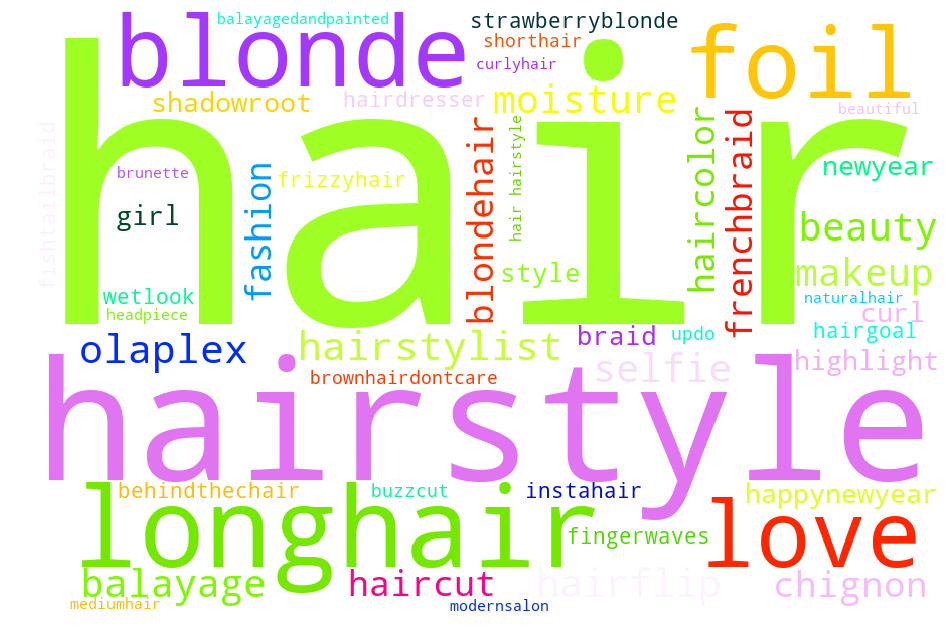

In [23]:
plt.figure(dpi = 80)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Most frequently used tags are (descending order): hair, hairstyle, longhair, blonde [etc]

In [24]:
sentences = tags_w_likes
model = word2vec.Word2Vec(sentences, size = 200)

2018-06-29 09:33:57,405 : INFO : collecting all words and their counts
2018-06-29 09:33:57,407 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-06-29 09:33:57,455 : INFO : collected 35911 word types from a corpus of 108294 raw words and 8125 sentences
2018-06-29 09:33:57,456 : INFO : Loading a fresh vocabulary
2018-06-29 09:33:57,483 : INFO : min_count=5 retains 2959 unique words (8% of original 35911, drops 32952)
2018-06-29 09:33:57,484 : INFO : min_count=5 leaves 63977 word corpus (59% of original 108294, drops 44317)
2018-06-29 09:33:57,497 : INFO : deleting the raw counts dictionary of 35911 items
2018-06-29 09:33:57,499 : INFO : sample=0.001 downsamples 56 most-common words
2018-06-29 09:33:57,500 : INFO : downsampling leaves estimated 57120 word corpus (89.3% of prior 63977)
2018-06-29 09:33:57,516 : INFO : estimated required memory for 2959 words and 200 dimensions: 6213900 bytes
2018-06-29 09:33:57,517 : INFO : resetting layer weights
2018-06-29 

In [25]:
model.most_similar("#balayage")
# finding similar hashtags 

/home/tharangni/Documents/misc/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-06-29 09:33:58,099 : INFO : precomputing L2-norms of word weight vectors


[('#balayagehighlights', 0.9999147057533264),
 ('#balayagedandpainted', 0.9998985528945923),
 ('#balayageombre', 0.9998736381530762),
 ('#hairpainting', 0.9998393654823303),
 ('#balayageartists', 0.9997296333312988),
 ('#olaplex', 0.9996975660324097),
 ('#hairbrained', 0.9996358156204224),
 ('#imallaboutdahair', 0.9996021389961243),
 ('#beautylaunchpad', 0.9995537400245667),
 ('#authentichairarmy', 0.999460756778717)]

In [26]:
# Using 2 or more word vectors to arriver at analogus words (vectors)
model.wv.most_similar(positive=['#haircut', '#christmas'])
# Most trending haircuts during Christmas (i.e. haircuts in christmas)

[('#bluntcut', 0.9998564720153809),
 ('#longhair', 0.9998456239700317),
 ('#wavyhair', 0.9998412132263184),
 ('#curls', 0.9998332858085632),
 ('#haircolour', 0.9998308420181274),
 ('#waves', 0.9998276233673096),
 ('#longhairdontcare', 0.9998271465301514),
 ('#newhair', 0.9998264312744141),
 ('#mediumhair', 0.9998250603675842),
 ('#strawberryblonde', 0.9998247623443604)]

### Ideas for further analysis in discovering relationships between hashtags:
- Use a clustering algorithm to get a bunch of "tag clusters" and see if posts are tagged with that similar list of tags
- Monthly tag popularity instead of a global one